Problem statement

Classify a X-Ray image as being normal or TB.

Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

Get images

In [3]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Define path

In [4]:
import pathlib

data_dir = "data/train/" # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('data/train')

Define classes

In [5]:
normal = list(data_dir.glob('Normal/*'))
tb = list(data_dir.glob('Tuberculosis/*'))

print("Length of normal: ", len(normal))
print("Length of tb: ", len(tb))

Length of normal:  3500
Length of tb:  700


Print random images

855
308


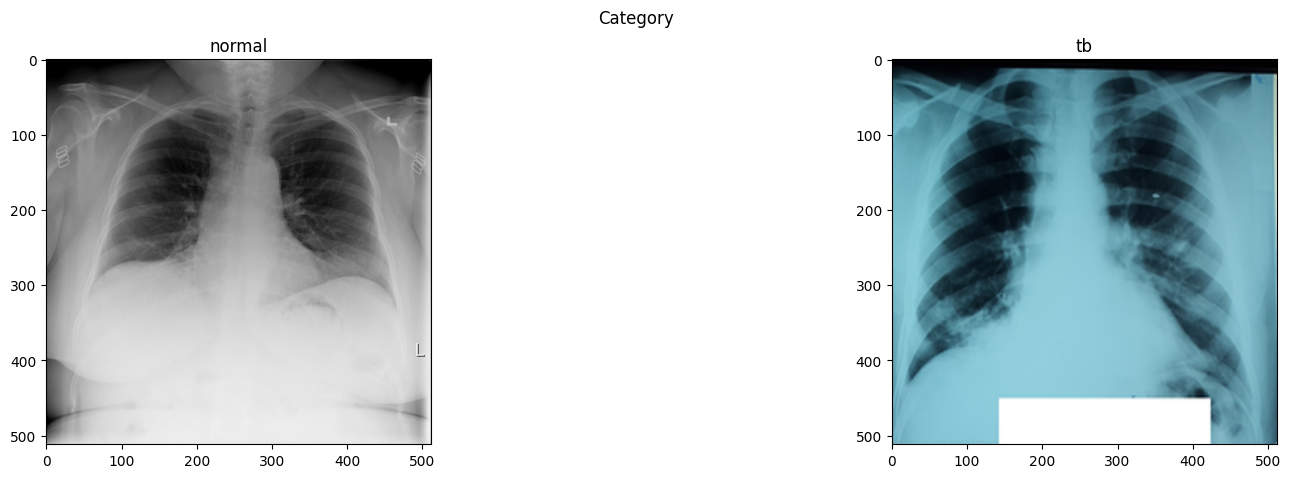

In [6]:
import matplotlib.image as img
import PIL.Image as Image

fig, ax = plt.subplots(ncols= 2, nrows = 1, figsize=(20,5))
fig.suptitle('Category')

rand_normal = np.random.randint(-1,len(normal))
print(rand_normal)

rand_tb = np.random.randint(-1, len(tb))
print(rand_tb)

normal_image = img.imread(normal[rand_normal])
tb_image = img.imread(tb[rand_tb])

ax[0].set_title('normal')
ax[1].set_title('tb')

ax[0].imshow(normal_image)
ax[1].imshow(tb_image)


Define dataframe

In [7]:
# contains the images path

df_images = {
    'normal' : normal,
    'tb' : tb
}

# contains numerical labels for the categories
df_labels = {
    'normal' : 0,
    'tb' : 1
}

Get shape of image

In [8]:
import cv2

img = cv2.imread(str(df_images['tb'][rand_tb])) # Converting it into numerical arrays
img.shape

(512, 512, 3)

Define X and y

In [9]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(df_labels[label])
print(len(X), len(y))

4200 4200


Convert X and y to numpy arrays

In [10]:
X = np.array(X)
y = np.array(y)

Split X and y into training, validation, and testing sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size = 0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3360, 224, 224, 3),
 (210, 224, 224, 3),
 (630, 224, 224, 3),
 (3360,),
 (210,),
 (630,))

Tensorflow

In [12]:
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_hub as hub
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import MobileNetV2, DenseNet169
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Lambda, Dense, Flatten
from glob import glob
from keras.models import Model
print(tf.__version__)

2.12.0


Normalise data

In [13]:
normalizer = tf.keras.layers.Rescaling(scale=1/255)

Define input shape to pretrained models

In [14]:
input_shape = (224, 224, 3)
input_layer = keras.Input(shape = (224, 224, 3))

Set up pretrained models

In [15]:
input_shape = (224, 224, 3)


vgg = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg.layers:
    layer.trainable = False


Define model

In [16]:
folders = glob('data/train/*')
x = Flatten()(vgg.output)

In [17]:
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1)
mc = ModelCheckpoint ('best.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping, mc])

Epoch 1/10


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


105/105 [==============================] - 1416s 13s/step - loss: 0.7467 - accuracy: 0.9667 - val_loss: 6.8038e-05 - val_accuracy: 1.0000
Epoch 2/10
105/105 [==============================] - 1350s 13s/step - loss: 0.0973 - accuracy: 0.9943 - val_loss: 0.6334 - val_accuracy: 0.9762
Epoch 3/10
105/105 [==============================] - 1350s 13s/step - loss: 0.2198 - accuracy: 0.9902 - val_loss: 0.1577 - val_accuracy: 0.9857
Epoch 4/10
105/105 [==============================] - 1346s 13s/step - loss: 0.0506 - accuracy: 0.9970 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/10
105/105 [==============================] - 1471s 14s/step - loss: 4.0253e-06 - accuracy: 1.0000 - val_loss: 3.8033e-08 - val_accuracy: 1.0000
Epoch 6/10
 79/105 [=====================>........] - ETA: 9:40 - loss: 4.1839e-06 - accuracy: 1.0000 

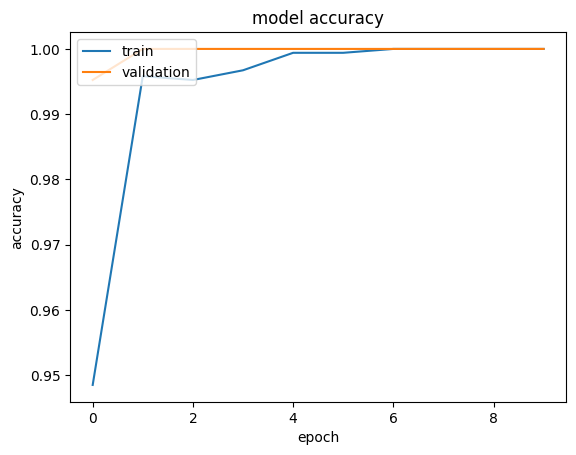

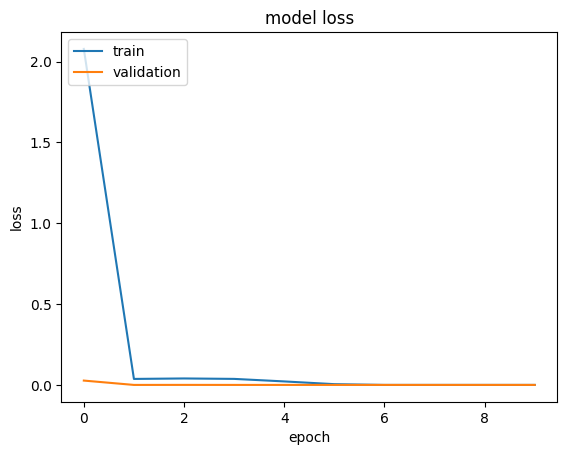

In [ ]:
# Plot accuracy and loss graphs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Make predictions

In [ ]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred_bool

10/10 [==============================] - 227s 23s/step


array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import accuracy_score

total_right = accuracy_score(y_test, y_pred_bool, normalize=False)
print(total_right)
accuracy = (total_right / len(y_test))
print(accuracy)

628
0.9968253968253968


In [ ]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 78s 4s/step - loss: 0.0092 - acc: 0.9984


[0.00920729897916317, 0.9984126687049866]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       527
           1       0.99      0.99      0.99       103

    accuracy                           1.00       630
   macro avg       0.99      0.99      0.99       630
weighted avg       1.00      1.00      1.00       630



In [ ]:
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

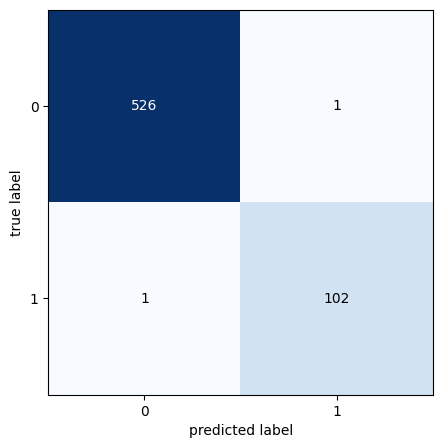

In [ ]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_test, y_pred_bool)

plot_confusion_matrix(cm, figsize=(5,5))

In [ ]:
model.save("TB2.h5")

In [ ]:
df = pd.DataFrame({'actual': y_test, 'predicted': y_pred_bool})
df

,actual,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
625,1,1
626,0,0
627,0,0
628,0,0


In [ ]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px

init_notebook_mode(connected=True)

acc = pd.DataFrame({'train': history.history['accaccuracy'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch', markers=True)
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = px.line(loss, x=loss.index, y=loss.columns[0::], title='Training and Evaluation Loss every Epoch', markers=True)
fig.show()

NameError: name 'px' is not defined